In [39]:
import os
import sys
import glob
import struct
import shutil
import numpy as np
import matplotlib.pyplot as plt

# Instructions
* The data you need are under ```/home/jovyan/share/TBP/RECON```
* You will need to copy ```__run__OSMAPOSL.par``` in your work folder
* You will need to copy ```root_header.hroot``` in your work folder
* Optional: You can copy ```total_2.root``` in this folder and in ```root_header.hroot``` edit the ```name of data file``` to point to the local file

In [6]:
shutil.copyfile(os.path.join(base_path, '__run__OSMAPOSL.par'), '__run__OSMAPOSL.par')
shutil.copyfile(os.path.join(base_path, 'root_header.hroot'), 'root_header.hroot')
shutil.copyfile(os.path.join(base_path, 'total_2.root'), 'total_2.root')

'root_header.hroot'

In [3]:
# The basis for our project

base_path = "/home/jovyan/share/TBP/RECON"
work_path = "/home/jovyan/share/USER"

if base_path == work_path:
    print("DO NOT GO ANY FURTHER YOU WILL BE REPLACING YOUR EXISTS CACHE FILES. CHANGE OUTPUT PATH.")

if not os.path.exists(work_path):
    os.mkdir(work_path)
os.chdir(work_path)

* Open ```__run__OSMAPOSL.par```
* Find the line ```maximum absolute segment number to process``` and set to a small number as 10
* Find the line ```normalisation pro data filename``` and set to the path ```/home/jovyan/share/TBP/RECON/ATTEN/acf.hs```
* Find the line ```recompute cache``` and set to "0"
* If you wish rename the ```output filename prefix``` to something else.

* As we try to avoid reading the ROOT files as listmode data as only make use of the optimized cache files
* From the cache files we need to remove the events that have a segment number larger than that the reconstruction expects.

In [70]:

# This must be the same number you set in the __run__OSMAPOSL.par
# Reduce the segment range
numSegments = 10
# Min Segment to keep
min_seg = -numSegments
max_seg = numSegments
print("Number of Segments to keep ", numSegments)
print("Min segment in output", min_seg)
print("Max segment in output", max_seg)

Number of Segments to keep  10
Min segment in output -10
Max segment in output 10


In [71]:
#
# Find all cacheFiles in path
#
cacheFilenames = glob.glob(os.path.join(base_path, 'my*'))
print(cacheFilenames)

['/home/jovyan/share/TBP/RECON/my_CACHE0.bin', '/home/jovyan/share/TBP/RECON/my_CACHE1.bin']


In [72]:
#
# Sanity Test. If the numbers below do not look reasonable. Abort!
#
with open(cacheFilenames[0], 'rb') as f:
    for i in range(10):
        record = f.read(28)
        Seg, TOF, View, Axial, Tang, Val, Frm = struct.unpack('5i1f1i', record)
        print("Bin: ", i, Seg, TOF, View, Axial, Tang, Frm, Val)
    f.close()

Bin:  0 -175 0 201 1 -138 1 1.0
Bin:  1 -25 0 178 72 -113 1 1.0
Bin:  2 53 0 304 173 46 1 1.0
Bin:  3 -200 0 290 11 -17 1 1.0
Bin:  4 151 0 99 4 -118 1 1.0
Bin:  5 -41 0 223 51 49 1 1.0
Bin:  6 -3 0 19 206 43 1 1.0
Bin:  7 -18 0 88 51 53 1 1.0
Bin:  8 188 0 237 1 -54 1 1.0
Bin:  9 185 0 178 36 41 1 1.0


In [85]:
events_read = 0
for curr_cache in cacheFilenames: 
    print("Processing cache file", curr_cache)
    output_list = []

    with open(curr_cache,'rb') as f:
        while 1: 
            record = f.read(28)

            if len(record) != 28: 
                break
            Seg, TOF, View, Axial, Tang, Val, Frm = struct.unpack('5i1f1i',record)
            if Seg <= min_seg or Seg >= max_seg:
                continue
                
            output_list.append([Seg, TOF, View, Axial, Tang, Val, Frm])
            events_read += 1
            if events_read % 500000 == 0: 
                print("Events read: ", events_read)
            # print("Bin: ", output_list[-1])
    f.close()

    output_cache_filepath = os.path.basename(curr_cache)
    print("OUTPUT at", output_cache_filepath)
    with open (str(output_cache_filepath), 'wb') as f:
        for bin in output_list: 
            f.write(struct.pack('5i1f1i', bin[0],\
                                bin[1],bin[2],\
                                    bin[3],bin[4],
                                    bin[5], bin[6]))
    f.close()

print("Finished!")
print("Events in cache:", events_read)

Processing cache file /home/jovyan/share/TBP/RECON/my_CACHE0.bin
Events read:  500000
Events read:  1000000
Events read:  1500000
Events read:  2000000
Events read:  2500000
Events read:  3000000
Events read:  3500000
Events read:  4000000
Events read:  4500000
Events read:  5000000
Events read:  5500000
Events read:  6000000
Events read:  6500000
Events read:  7000000
Events read:  7500000
Events read:  8000000
Events read:  8500000
Events read:  9000000
Events read:  9500000
Events read:  10000000
Events read:  10500000
OUTPUT at my_CACHE0.bin
Processing cache file /home/jovyan/share/TBP/RECON/my_CACHE1.bin
Events read:  500000
Events read:  1000000
Events read:  1500000
Events read:  2000000
Events read:  2500000
Events read:  3000000
Events read:  3500000
Events read:  4000000
Events read:  4500000
Events read:  5000000
Events read:  5500000
Events read:  6000000
Events read:  6500000
Events read:  7000000
Events read:  7500000
Events read:  8000000
Events read:  8500000
Events rea

* Now you can run ```OSMAPOSL __run__OSMAPOSL.par```
* And wait.
* If you run the reconstruction with this settings first time you need to have ```recompute sensitivity``` set to ```1```. But reconstructing again with the same settings you can skip recomputing the sensitivity.
* 

Max value:  5897.735


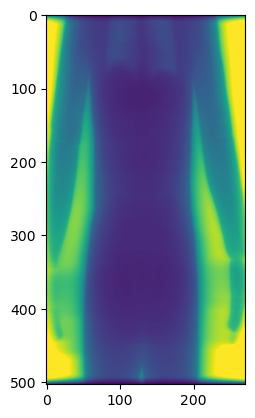

In [77]:
image_filename = 'sens.v'
array = np.fromfile(image_filename, dtype=np.float32).reshape([503, 271, 271])
print("Max value: ", array.max())
plt.imshow(array[:, :, 120], vmin = 0, vmax=array.max()*0.75)

Max value:  0.026072022


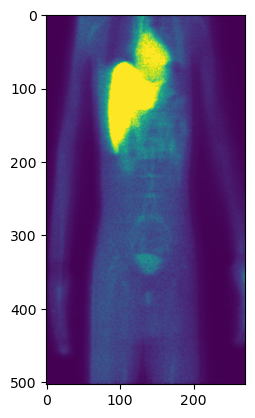

In [92]:
image_filename = '_del_2.v'
array = np.fromfile(image_filename, dtype=np.float32).reshape([503, 271, 271])
print("Max value: ", array.max())
plt.imshow(array[:, :, 140], vmin = 0, vmax=array.max()*0.35)

# Introducing gaps
* It has been proposed to reduce the cost by introducing gaps in the geometry. 
* It is straingforward to introduce gaps in the radial positions, and exclude detectors
* The following function ```is_gap``` will exclude blocks or modules (buckets). 

In [99]:
# Reject blocks 
reject_blks = False
# Reject i_th block
blk_rejection = 3

# Reject buckets
reject_buckets = True
# Reject i_th bucket
bucket_rejection = 3

In [100]:
# Don't edit these numbers
num_detectors = 840
num_rings = 252
ring_spacing = 2.85
num_xtal_per_blk_trans = 7
num_xtal_per_blk_axial = 6
num_blk_per_bucket_trans = 5
num_blk_per_bucket_axial = 14
num_buckets = 24
num_full_rings = 3

In [101]:
def get_detector_pair(Seg, View, Axial, Tang):
    d1 =  (View + (Tang //2) + num_detectors) % num_detectors
    d2 =  (View - ((Tang + 1) //2) + num_detectors / 2) % num_detectors;

    return d1, d2

def is_gap(Seg, View, Axial, Tang):
    
    d1, d2 = get_detector_pair(Seg, View, Axial, Tang)

    if reject_blks:
        if(d1 // num_blk_per_bucket_trans % blk_rejection): 
            return True # is gap
        if(d2 // num_blk_per_bucket_trans % blk_rejection): 
            return True # is gap
    
    if reject_buckets:
        if(d1 // num_buckets % bucket_rejection): 
            return True # is gap
        if(d2 // num_buckets % bucket_rejection): 
            return True # is gap
    return False

In [102]:
events_read = 0
for curr_cache in cacheFilenames: 
    print("Processing cache file", curr_cache)
    output_list = []

    with open(curr_cache,'rb') as f:
        while 1: 
            record = f.read(28)

            if len(record) != 28: 
                break
            Seg, TOF, View, Axial, Tang, Val, Frm = struct.unpack('5i1f1i',record)
            if Seg <= min_seg or Seg >= max_seg:
                continue

            if is_gap(Seg, View, Axial, Tang):
                continue
                
            output_list.append([Seg, TOF, View, Axial, Tang, Val, Frm])
            events_read += 1
            if events_read % 500000 == 0: 
                print("Events read: ", events_read)
            # print("Bin: ", output_list[-1])
    f.close()

    output_cache_filepath = os.path.basename(curr_cache)
    print("OUTPUT at", output_cache_filepath)
    with open (str(output_cache_filepath), 'wb') as f:
        for bin in output_list: 
            f.write(struct.pack('5i1f1i', bin[0],\
                                bin[1],bin[2],\
                                    bin[3],bin[4],
                                    bin[5], bin[6]))
    f.close()

print("Finished!")
print("Events in cache:", events_read)

Processing cache file /home/jovyan/share/TBP/RECON/my_CACHE0.bin
Events read:  500000
Events read:  1000000
OUTPUT at my_CACHE0.bin
Processing cache file /home/jovyan/share/TBP/RECON/my_CACHE1.bin
Events read:  500000
Events read:  1000000
OUTPUT at my_CACHE1.bin
Finished!


* Now run the reconstruction
* If the num of segments is the same you can skip the calculation of the sensitivity image

Max value:  0.010710166


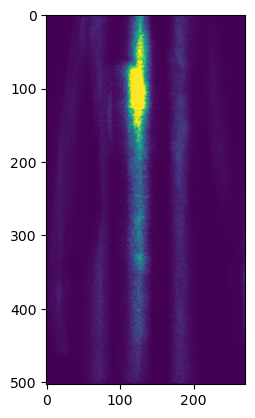

In [106]:
image_filename = '_del_2.v'
array = np.fromfile(image_filename, dtype=np.float32).reshape([503, 271, 271])
print("Max value: ", array.max())
plt.imshow(array[:, :, 140], vmin = 0, vmax=array.max()*0.35)

In [104]:
# Reject blocks 
reject_blks = True
# Reject i_th block
blk_rejection = 3

# Reject buckets
reject_buckets = False
# Reject i_th bucket
bucket_rejection = 3

In [105]:
events_read = 0
for curr_cache in cacheFilenames: 
    print("Processing cache file", curr_cache)
    output_list = []

    with open(curr_cache,'rb') as f:
        while 1: 
            record = f.read(28)

            if len(record) != 28: 
                break
            Seg, TOF, View, Axial, Tang, Val, Frm = struct.unpack('5i1f1i',record)
            if Seg <= min_seg or Seg >= max_seg:
                continue

            if is_gap(Seg, View, Axial, Tang):
                continue
                
            output_list.append([Seg, TOF, View, Axial, Tang, Val, Frm])
            events_read += 1
            if events_read % 500000 == 0: 
                print("Events read: ", events_read)
            # print("Bin: ", output_list[-1])
    f.close()

    output_cache_filepath = os.path.basename(curr_cache)
    print("OUTPUT at", output_cache_filepath)
    with open (str(output_cache_filepath), 'wb') as f:
        for bin in output_list: 
            f.write(struct.pack('5i1f1i', bin[0],\
                                bin[1],bin[2],\
                                    bin[3],bin[4],
                                    bin[5], bin[6]))
    f.close()

print("Finished!")
print("Events in cache:", events_read)

Processing cache file /home/jovyan/share/TBP/RECON/my_CACHE0.bin
Events read:  500000
Events read:  1000000
OUTPUT at my_CACHE0.bin
Processing cache file /home/jovyan/share/TBP/RECON/my_CACHE1.bin
Events read:  1500000
Events read:  2000000
Events read:  2500000
OUTPUT at my_CACHE1.bin
Finished!
Events in cache: 2519458


Max value:  0.01204565


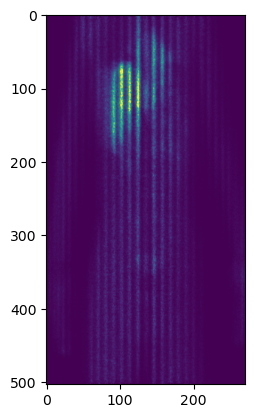

In [107]:
image_filename = '_del_2.v'
array = np.fromfile(image_filename, dtype=np.float32).reshape([503, 271, 271])
print("Max value: ", array.max())
plt.imshow(array[:, :, 140], vmin = 0, vmax=array.max()*0.35)